In [1]:
!nvidia-smi

Thu Dec  7 11:40:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-12GB            Off| 00000000:82:00.0 Off |                    0 |
| N/A   35C    P0               25W / 250W|      0MiB / 12288MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler, SGD

from torchsummary import summary
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

# Local files imports
from plant_model import PlantResNet18, PlantTrainer
from plant_constants import mean, std, num_classes, input_shape, batch_size, train_dir, valid_dir, test_dir
from plot_evaluation import plot_loss_and_acc, plot_time_and_memory_usage, plot_confusion_matrix

## Use Tuned Hyperparameters

In [3]:
# Best hps
lr_rate = 0.09571183178798688
step_size = 6
weight_decay = 1.075254487489493e-05
momentum = 0.9083404509853434

In [4]:
num_workers = 4
num_epochs = 10

In [5]:
# Step 1: Check Hardware Information--------------------------------------------------
print("CUDA available" if torch.cuda.is_available() else "CUDA unavailable")
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()

    
# Step 2: Data Loading----------------------------------------------------------------
torch.manual_seed(0)
# Define data transforms for training, validation, and testing
def data_loaders(num_workers, batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Create datasets using ImageFolder
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False, num_workers=num_workers)
    
    return train_loader, valid_loader

train_loader, valid_loader = data_loaders(num_workers, batch_size)


# Step 3: Define Model----------------------------------------------------------------
model = PlantResNet18(num_classes, False)
model.to(device)


# Step 4: Model Training--------------------------------------------------------------
# Hyperparameters please refer the plant_hps.py

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = SGD(model.fc.parameters(), lr=lr_rate, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler
scheduler =  lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

# Create trainer
trainer_name = f"final__trainer"
trainer = PlantTrainer(trainer_name, device, model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs)

# Start training
trainer.train_model()
trainer.display_info()

# Store trainer info
with open(f"res/{trainer_name}.pkl", "wb") as file:
    pickle.dump(trainer, file)

CUDA available
Epoch [1/10]------------------------------------------------------------------------
| Train Loss: 5.7483 | Train Acc: 0.3103 | Val Loss: 3.9926, Val Acc: 0.3334
| Elapsed Time: 167.4007 s | Max GPU Memory Alloc: 1959.4707 MB
Epoch [2/10]------------------------------------------------------------------------
| Train Loss: 3.0118 | Train Acc: 0.4413 | Val Loss: 2.8055, Val Acc: 0.4561
| Elapsed Time: 163.9486 s | Max GPU Memory Alloc: 1959.4722 MB
Epoch [3/10]------------------------------------------------------------------------
| Train Loss: 2.6932 | Train Acc: 0.4853 | Val Loss: 2.6643, Val Acc: 0.4850
| Elapsed Time: 163.9407 s | Max GPU Memory Alloc: 1959.4731 MB
Epoch [4/10]------------------------------------------------------------------------
| Train Loss: 1.2217 | Train Acc: 0.6560 | Val Loss: 1.2503, Val Acc: 0.6513
| Elapsed Time: 164.6620 s | Max GPU Memory Alloc: 1959.4741 MB
Epoch [5/10]---------------------------------------------------------------------

## Check Training and Validation Acc and Loss

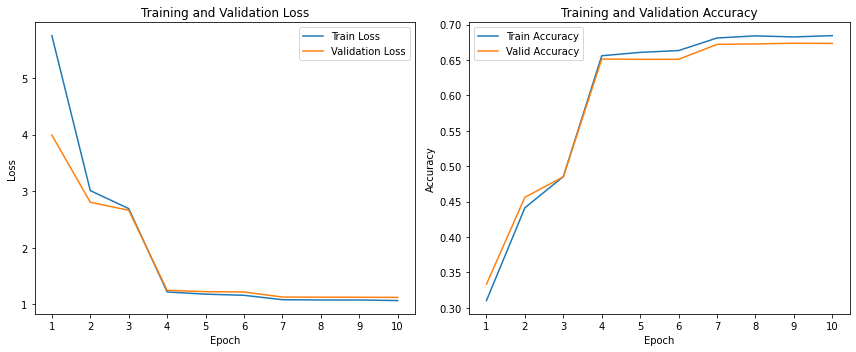

In [6]:
# Step 5: Model Evaluation---------------------------------------------------------------
epoch_list = [i + 1 for i in range(num_epochs)]
plot_loss_and_acc(trainer_name, epoch_list, trainer.history)

## Check on test dataset after final training

In [7]:
test_dataset = datasets.ImageFolder(root=test_dir, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=64)

In [8]:
def test_accuracy(loader, device, model):
    corrects = 0.0
    all_preds = []
    all_labels = []
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.data.cpu().numpy())

    test_acc = (corrects / len(loader.dataset)).item()
    print(f"Test acc: {test_acc * 100:.2f}%")
    
    # Create classification report
    report = classification_report(all_labels, all_preds, target_names=loader.dataset.classes)
    print(report)

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, loader.dataset.classes)

In [9]:
test_accuracy(valid_loader, device, model)

Test acc: 67.33%
                                                   precision    recall  f1-score   support

                               Apple___Apple_scab       0.64      0.58      0.61       504
                                Apple___Black_rot       0.63      0.60      0.62       497
                         Apple___Cedar_apple_rust       0.69      0.68      0.68       440
                                  Apple___healthy       0.59      0.67      0.63       502
                              Blueberry___healthy       0.74      0.78      0.76       454
         Cherry_(including_sour)___Powdery_mildew       0.70      0.76      0.73       421
                Cherry_(including_sour)___healthy       0.74      0.77      0.76       456
Corn_(maize)___Cercospora_leaf_spotGray_leaf_spot       0.74      0.62      0.67       410
                      Corn_(maize)___Common_rust_       0.96      0.97      0.96       477
              Corn_(maize)___Northern_Leaf_Blight       0.74      0.82  